In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [ ]:
# 📌 Load Data
df = pd.read_csv("final_parkinsons_features.csv")

In [6]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    axs[0].plot(history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[0].set_title(f"Model Accuracy - {title}")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Loss Plot
    axs[1].plot(history.history['loss'], label="Train Loss")
    axs[1].plot(history.history['val_loss'], label="Validation Loss")
    axs[1].set_title(f"Model Loss - {title}")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()

In [5]:
df.head()

,Unnamed: 0,Gait_Cycle_Percent,Left_Ankle_Ankle_Dorsi_Plantarflexion_PF_DF,Left_Hip_Hip_Flexion_Extension_EXT_FLX,Left_Knee_Knee_Flx_Extension_EXT_FLX,Right_Ankle_Ankle_Dorsi_Plantarflexion_PF_DF,Right_Hip_Hip_Flexion_Extension_EXT_FLX,Right_Knee_Knee_Flx_Extension_EXT_FLX,Subject_ID,label,...,Left_Knee_Ang_Knee_Flx_Extension_Variability,Right_Ankle_Ang_Ankle_Dorsi_Plantarflexion_Variability,Right_Hip_Ang_Hip_Flexion_Extension_Variability,Right_Knee_Ang_Knee_Flx_Extension_Variability,Left_Ankle_Ang_Ankle_Dorsi_Plantarflexion_Acceleration,Left_Hip_Ang_Hip_Flexion_Extension_Acceleration,Left_Knee_Ang_Knee_Flx_Extension_Acceleration,Right_Ankle_Ang_Ankle_Dorsi_Plantarflexion_Acceleration,Right_Hip_Ang_Hip_Flexion_Extension_Acceleration,Right_Knee_Ang_Knee_Flx_Extension_Acceleration
0,0,1,-2.37648,34.02794,16.14490,1.87055,33.60558,11.36783,SUB01_1,1,...,18.945746,7.692659,15.308019,18.810668,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,1,2,-1.87879,33.60433,16.86324,0.98626,33.50635,11.34289,SUB01_1,1,...,18.945746,7.692659,15.308019,18.810668,0.49769,-0.42361,0.71834,-0.88429,-0.09923,-0.02494
2,2,3,-1.15549,33.26338,17.86806,0.16397,33.50398,11.92080,SUB01_1,1,...,18.945746,7.692659,15.308019,18.810668,0.72330,-0.34095,1.00482,-0.82229,-0.00237,0.57791
3,3,4,-0.21892,33.00112,19.09299,-0.47002,33.58014,13.01924,SUB01_1,1,...,18.945746,7.692659,15.308019,18.810668,0.93657,-0.26226,1.22493,-0.63399,0.07616,1.09844
4,4,5,0.88757,32.78223,20.42713,-0.80742,33.70621,14.51952,SUB01_1,1,...,18.945746,7.692659,15.308019,18.810668,1.10649,-0.21889,1.33414,-0.33740,0.12607,1.50028


In [3]:
df_clean = df.dropna().reset_index(drop=True)

# Then split into X and y
X = df_clean.drop(columns=["label","Gait_Cycle_Percent","Subject_ID","Unnamed: 0"])
y = df_clean["label"]

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA - SAME number of components as QNN input
num_pca_components = 4  # Adjust to match QNN's input size
pca = PCA(n_components=num_pca_components)
X_pca = pca.fit_transform(X)

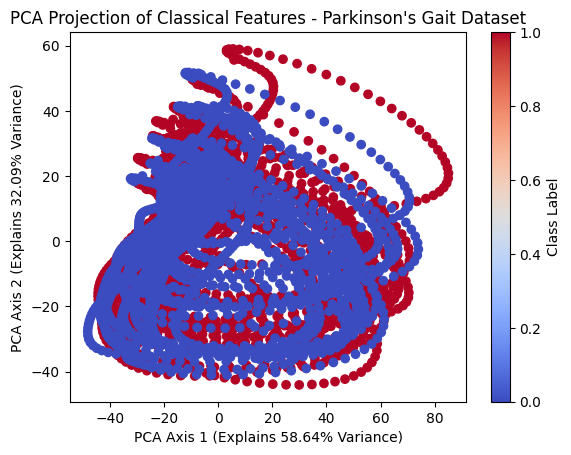

In [7]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm")
plt.xlabel("PCA Axis 1 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PCA Axis 2 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[1] * 100))
plt.title("PCA Projection of Classical Features - Parkinson's Gait Dataset")
plt.colorbar(label="Class Label")
plt.show()

In [ ]:
# Convert labels to one-hot encoding
num_classes = 2  # Adjust for your dataset
y_onehot = to_categorical(y, num_classes=num_classes)

# Split once: train + temp
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y_onehot, random_state=42)

# Split again: train + val (from temp)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Remove MinMaxScaler, keep StandardScaler
scaler = StandardScaler()  # StandardScaler ensures proper feature scaling for PCA
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Convert to float32 (required for TensorFlow)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
X_val = X_val.astype("float32")

In [10]:
# Sequential model (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, verbose=1)

Epoch 1/20
91/91 [==============================] - 5532s 73ms/step - loss: 0.6928 - accuracy: 0.5148 - val_loss: 0.6929 - val_accuracy: 0.5175
Epoch 2/20
91/91 [==============================] - 4s 46ms/step - loss: 0.6922 - accuracy: 0.5234 - val_loss: 0.6927 - val_accuracy: 0.5175
Epoch 3/20
91/91 [==============================] - 4s 47ms/step - loss: 0.6919 - accuracy: 0.5230 - val_loss: 0.6925 - val_accuracy: 0.5206
Epoch 4/20
91/91 [==============================] - 4s 40ms/step - loss: 0.6916 - accuracy: 0.5196 - val_loss: 0.6922 - val_accuracy: 0.5216
Epoch 5/20
91/91 [==============================] - 3s 37ms/step - loss: 0.6913 - accuracy: 0.5241 - val_loss: 0.6921 - val_accuracy: 0.5216
Epoch 6/20
91/91 [==============================] - 4s 40ms/step - loss: 0.6910 - accuracy: 0.5196 - val_loss: 0.6919 - val_accuracy: 0.5196
Epoch 7/20
91/91 [==============================] - 4s 39ms/step - loss: 0.6907 - accuracy: 0.5230 - val_loss: 0.6918 - val_accuracy: 0.5186
Epoch 8/20

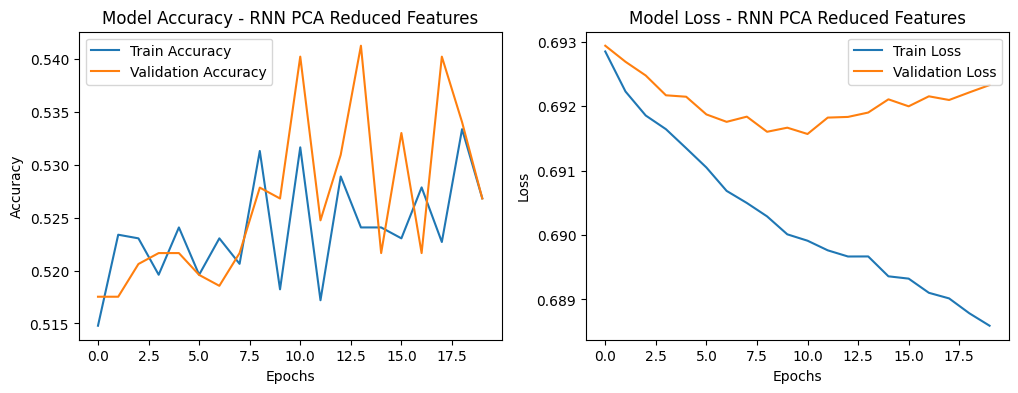

In [11]:
plot_history(history, "RNN PCA Reduced Features")

31/31 [==============================] - 0s 11ms/step


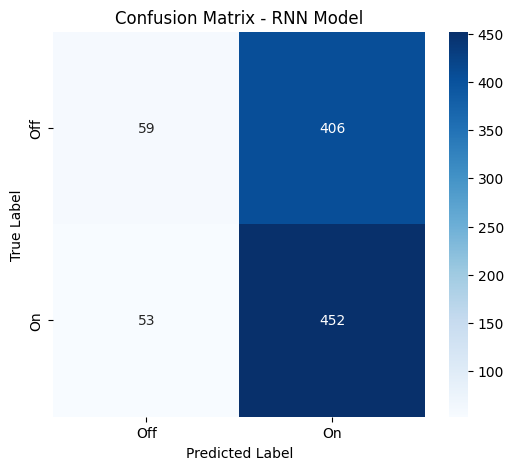

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.13      0.20       465
           1       0.53      0.90      0.66       505

    accuracy                           0.53       970
   macro avg       0.53      0.51      0.43       970
weighted avg       0.53      0.53      0.44       970



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 🔹 Step 1: Get Model Predictions
y_pred_probs = model.predict(X_test)  # Get prediction probabilities


# 🔹 Step 2: Adjust Decision Threshold
threshold = 0.5
y_pred = (y_pred_probs[:, 0] > threshold).astype(int)

# 🔹 Step 3: Convert one-hot encoded labels (if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check safely
    y_test = np.argmax(y_test, axis=1)  # Converts one-hot labels back to single-class


# 🔹 Step 4: Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 🔹 Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Off", "On"], yticklabels=["Off", "On"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - RNN Model")
plt.show()

# 🔹 Step 6: Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"DNN Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

31/31 [==============================] - 1s 22ms/step - loss: 0.6926 - accuracy: 0.5268
DNN Test Accuracy: 0.5268 | Loss: 0.6926


In [14]:
# Get model predictions
y_pred_probs = model.predict(X_test)

# Check confidence distribution
print("Min Confidence:", np.min(y_pred_probs))
print("Max Confidence:", np.max(y_pred_probs))
print("Mean Confidence:", np.mean(y_pred_probs))

31/31 [==============================] - 0s 13ms/step
Min Confidence: 0.3524422
Max Confidence: 0.61013925
Mean Confidence: 0.5261533


31/31 [==============================] - 0s 13ms/step


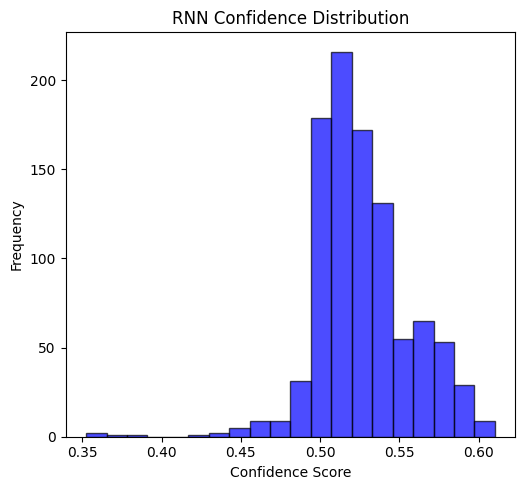

In [15]:
y_true_qnn = y_test  # Convert one-hot labels to class labels
y_pred_qnn = np.argmax(model.predict(X_test), axis=1)
confidences_qnn = np.max(model.predict(X_test), axis=1)

# Convert to numpy arrays if needed
qnn_confidences = np.array(confidences_qnn)  # Replace with your QNN confidence list

plt.figure(figsize=(10, 5))

# QNN Confidence Distribution
plt.subplot(1, 2, 1)
plt.hist(qnn_confidences, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("RNN Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# K-Fold

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define number of folds
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Placeholder for epoch-wise averaging
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold+1}/{k}")

    y_train = y_train.reset_index(drop=True)

    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Sequential model (LSTM)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss="binary_crossentropy",
                metrics=["accuracy"])

    # Train model
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=1)

    # Store per-epoch results
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate model
    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")


Training Fold 1/5
Epoch 1/20
73/73 [==============================] - 14s 66ms/step - loss: 0.6926 - accuracy: 0.5327 - val_loss: 0.6937 - val_accuracy: 0.4931
Epoch 2/20
73/73 [==============================] - 3s 36ms/step - loss: 0.6919 - accuracy: 0.5292 - val_loss: 0.6941 - val_accuracy: 0.4931
Epoch 3/20
73/73 [==============================] - 2s 34ms/step - loss: 0.6915 - accuracy: 0.5292 - val_loss: 0.6945 - val_accuracy: 0.4931
Epoch 4/20
73/73 [==============================] - 2s 32ms/step - loss: 0.6913 - accuracy: 0.5292 - val_loss: 0.6951 - val_accuracy: 0.4931
Epoch 5/20
73/73 [==============================] - 2s 32ms/step - loss: 0.6909 - accuracy: 0.5292 - val_loss: 0.6951 - val_accuracy: 0.4931
Epoch 6/20
73/73 [==============================] - 2s 33ms/step - loss: 0.6908 - accuracy: 0.5292 - val_loss: 0.6949 - val_accuracy: 0.4931
Epoch 7/20
73/73 [==============================] - 2s 32ms/step - loss: 0.6907 - accuracy: 0.5292 - val_loss: 0.6950 - val_accuracy: 


Final K-Fold Accuracy: 0.5549


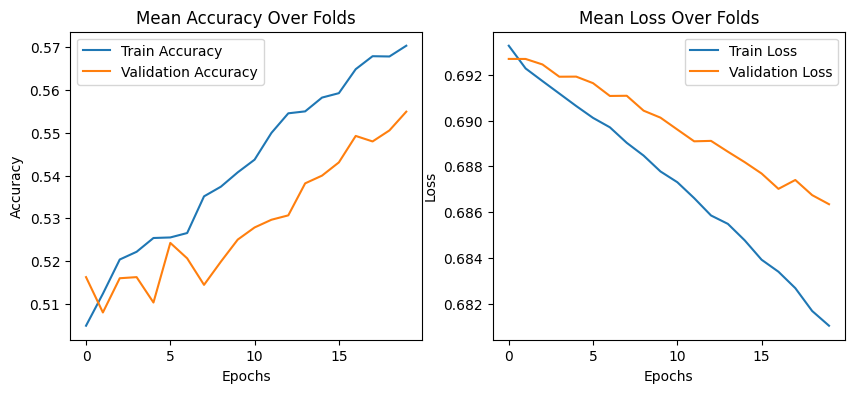

In [ ]:
# Convert lists to NumPy arrays for easy averaging
train_accuracies = np.array(train_accuracies)
val_accuracies = np.array(val_accuracies)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Compute mean accuracy/loss across folds
mean_train_acc = np.mean(train_accuracies, axis=0)
mean_val_acc = np.mean(val_accuracies, axis=0)
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# 🎯 Final mean accuracy across folds
final_accuracy = np.mean(val_accuracies[:, -1])
print(f"\nFinal K-Fold Accuracy: {final_accuracy:.4f}")

# 📊 Plot Accuracy Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, label='Train Accuracy')
plt.plot(mean_val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy Over Folds")
plt.legend()

# 📊 Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, label='Train Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mean Loss Over Folds")
plt.legend()

plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Convert lists to numpy arrays
folds = list(range(1, len(train_accuracies) + 1))

# Create DataFrame with results per fold
df_results = pd.DataFrame({
    'Fold': folds,
    'Final Train Accuracy': [train_acc[-1] for train_acc in train_accuracies],
    'Final Validation Accuracy': [val_acc[-1] for val_acc in val_accuracies],
    'Final Train Loss': [train_loss[-1] for train_loss in train_losses],
    'Final Validation Loss': [val_loss[-1] for val_loss in val_losses]
})

# Print results
print("\n📊 K-Fold Cross-Validation Results:\n")
print(df_results)

# Compute summary statistics (mean & std deviation)
df_summary = df_results.describe().loc[['mean', 'std']]
print("\n📌 Summary Statistics (Mean & Std Deviation):\n")
print(df_summary)


📊 K-Fold Cross-Validation Results:

   Fold  Final Train Accuracy  Final Validation Accuracy  Final Train Loss  \
0     1              0.564152                   0.565722          0.683375   
1     2              0.575758                   0.543814          0.680371   
2     3              0.573179                   0.561856          0.683938   
3     4              0.574283                   0.541936          0.677105   
4     5              0.564293                   0.561290          0.680450   

   Final Validation Loss  
0               0.684885  
1               0.690334  
2               0.685351  
3               0.685960  
4               0.685212  

📌 Summary Statistics (Mean & Std Deviation):

          Fold  Final Train Accuracy  Final Validation Accuracy  \
mean  3.000000              0.570333                   0.554924   
std   1.581139              0.005653                   0.011150   

      Final Train Loss  Final Validation Loss  
mean          0.681048             